TODO 
- [x] use pytorch dists to samples and get density in order to make loss
- [ ] check equations
- [ ] check loss should be negative
- make mdrnn just output sigma, mu, pi. We don't need the hidden input?
- [x] train
    - [ ] mix up multiple batches?
    - [ ] make sure it's learning
    - [x] plot
    

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
import torch
from torch.nn import functional as F
from torch.autograd import Variable
from torch import nn, optim
import torch.utils.data

# load as dask array
import dask.array as da
import dask
import h5py

import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from vae import VAE5, loss_function
from helpers.summarize import TorchSummarizeDf
from helpers.dataset import NumpyDataset, TQDMDaskProgressBar, load_npzs
from rnn import MDNRNN

# Init

In [4]:
cuda= torch.cuda.is_available()
env_name='sonic256'

num_epochs=200
batch_size = 6
seq_len = 6

image_size=256
action_dim = 12
chunksize=1000

data_cache_file = '/data/tmp/sonic_rnn_256.hdf5'

# Load Data

In [5]:
# load as dask array
filenames = sorted(glob.glob('/data/vae/obs_data_' + env_name + '_*.npz'))
filenames_actions = sorted(glob.glob('/data/vae/action_data_' + env_name + '_*.npz'))
assert len(filenames)==len(filenames_actions)

if not os.path.isfile(data_cache_file):
    data_train = load_npzs(filenames, shuffle=False)
    print(data_train)
    with TQDMDaskProgressBar():
        da.to_hdf5(data_cache_file, '/x', data_train)
       
    # clear mem
    del data_train 
    import gc
    gc.collect()
    
    y_train = load_npzs(filenames_actions, shuffle=False)
    print(y_train)
    with TQDMDaskProgressBar():
        da.to_hdf5(data_cache_file, '/y', y_train)
       
    # clear mem
    del y_train 
    import gc
    gc.collect()

In [6]:
# os.remove(data_cache_file)

In [7]:
# load
data = da.from_array(h5py.File(data_cache_file, mode='r')['x'], chunks=(chunksize, image_size, image_size, 3))
actions = da.from_array(h5py.File(data_cache_file, mode='r')['y'], chunks=(chunksize, action_dim))
data
data_split = int(len(data)*0.8)
data_train = data[:data_split]
data_test = data[data_split:]
actions_train = actions[:data_split]
actions_test = actions[data_split:]
data_train.shape, actions_train.shape

((96000, 256, 256, 3), (96000, 12))

In [8]:
actions.shape, data.shape

((120000, 12), (120000, 256, 256, 3))

In [9]:
data_test.shape, actions_test.shape

((24000, 256, 256, 3), (24000, 12))

In [10]:

dataset_train = NumpyDataset(data_train, actions_train)
loader_train = torch.utils.data.DataLoader(dataset_train, pin_memory=True, shuffle=False, batch_size=batch_size*seq_len, drop_last=True)


dataset_test = NumpyDataset(data_test, actions_test)
loader_test = torch.utils.data.DataLoader(dataset_test, pin_memory=True, shuffle=False, batch_size=batch_size*seq_len, drop_last=True)

dataset_train, loader_train

(<helpers.dataset.NumpyDataset at 0x7fc7f36aa7f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc7f36aa860>)

# Load VAE

In [11]:
# Load VAE
vae = VAE5(image_size=image_size, z_dim=128, conv_dim=64, code_dim=8, k_dim=1024)
if cuda:
    vae.cuda()

# # Resume
NAME='VAE5_3bigx256_1024z_CVAE_v2'
save_file = f'./models/{NAME}_state_dict.pkl'
if os.path.isfile(save_file):
    state_dict = torch.load(save_file)
    vae.load_state_dict(state_dict)
    print(f'loaded {save_file}')

# Train

In [12]:
# Plot reconstructions
def plot_results(loader, n=2, epoch=0, figsize=(9,6)):
    vae.eval()
    mdnrnn.eval()
    
    observations, actions = next(iter(loader))
    
    X = Variable(observations.transpose(1,3))
    if cuda:
        X=X.cuda()
    Y, mu_vae, logvar = vae.forward(X)
    loss_vae = loss_function(Y, X, mu_vae, logvar)
    
    # TODO do we want to sample in test or training mode?
    z_v = vae.sample(mu_vae, logvar)
    z_v = z_v.view(batch_size, seq_len, -1)

    # Forward
    actions_v = Variable(actions).float()
    actions_v = actions_v.view(batch_size, seq_len, -1)
    if cuda:
        z_v=z_v.cuda()
        actions_v=actions_v.cuda()
    pi, mu, sigma, hidden_state = mdnrnn.forward(z_v, actions_v)

    loss = mdnrnn.rnn_loss(z_v, pi, mu, sigma)
    
    # TODO tidy the following few lines
#     seq_len2 = mu.size(1)
    mu = mu.mean(2).view((batch_size*seq_len, mdnrnn.z_dim))
    X_pred = vae.decode(mu)
    _, channels, height, width = X.size()
    X_pred = X_pred.view((batch_size, seq_len, channels, height, width))
    X_pred = X_pred[:, -1]
    
    for i in np.linspace(0,batch_size-2,n):
        i=int(i)
        y=Y[i].cpu().data.transpose(0,2).numpy()
        x_orig = X[i].transpose(0,2).data.cpu().numpy()
        x_next = X[i+1].transpose(0,2).data.cpu().numpy()
        x_pred = X_pred[i].transpose(0,2).data.cpu().numpy()
        loss_vae_i = loss_vae[i].cpu().data.item()
        loss_i = loss[i].cpu().data.item()
        
        plt.figure(figsize=figsize)
        
        plt.subplot(2, 3, 1)
        plt.axis("off")
        plt.title('original')
        plt.imshow(x_orig)

        plt.subplot(2, 3, 4)
        plt.axis("off")
        plt.imshow(y)
        plt.title('reconstructed')
           
        plt.subplot(2, 3, 2)
        plt.axis("off")
        plt.imshow(x_next)
        plt.title('true next')
        
        plt.subplot(2, 3, 5)
        plt.axis("off")
        plt.imshow(x_pred)
        plt.title('pred next')
        
        plt.subplot(2, 3, 3)
        plt.axis("off")
        plt.imshow(np.abs(x_orig-x_next))
        plt.title('actual changes')
        
        plt.subplot(2, 3, 6)
        plt.axis("off")
        plt.imshow(np.abs(y[i]-x_pred))
        plt.title('predicted changes')

        plt.suptitle('epoch {}, index {}, vae_loss {:2.4f}, loss {:2.4f}'.format(epoch, i, loss_vae[i].cpu().data.item(), loss[i].cpu().data.item()))
#         plt.subplots_adjust(wspace=-.4, hspace=.1)#, bottom=0.1, right=0.8, top=0.9)
        plt.show()
        


In [13]:
import collections

def train(loader, vae, mdnrnn, optimizer, test=False, cuda=True):
    vae.eval()
    if test:
        mdnrnn.eval()
    else:
        mdnrnn.train()
    info = collections.defaultdict(list)
    hidden_state = None

    with tqdm(total=len(loader)*loader.batch_size, mininterval=0.5, desc='test' if test else 'training') as prog:
        for i, (observations, actions) in enumerate(loader):
            X = Variable(observations.transpose(1,3))
            if cuda:
                X=X.cuda()
            Y, mu_vae, logvar = vae.forward(X)
            # TODO do we want to sample in test or training mode?
            z_v = vae.sample(mu_vae, logvar)
            z_v = z_v.view(batch_size, seq_len, -1)

            # Forward
            actions_v = Variable(actions).float()
            actions_v = actions_v.view(batch_size, seq_len, -1)
            if cuda:
                z_v=z_v.cuda()
                actions_v=actions_v.cuda()
            pi, mu, sigma, hidden_state = mdnrnn.forward(z_v, actions_v)

            loss = mdnrnn.rnn_loss(z_v, pi, mu, sigma).mean()
            info['loss'].append(loss.cpu().data.numpy())

            if not test:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            prog.update(loader.batch_size)
            prog.desc='loss={:2.4f}'.format(np.mean(info['loss']))

        print('[{}/{}] loss={:2.4f}'.format(i, len(loader)*batch_size, np.mean(info['loss'])))
        prog.close()

    return info

## Init

In [14]:
# Load MDRNN
z_dim, action_dim, hidden_size, n_mixture, temp = 1024, 12, 512, 5, 0.0


mdnrnn = MDNRNN(z_dim, action_dim, hidden_size, n_mixture, temp)

if cuda:
    mdnrnn = mdnrnn.cuda()

optimizer = optim.Adam(mdnrnn.parameters(), lr=1e-4)
import torch.optim.lr_scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

In [15]:
# # Resume?
NAME='RNN_v3_256'
save_file = f'./models/{NAME}_state_dict.pkl'
if os.path.isfile(save_file):
    state_dict = torch.load(f'./models/{NAME}_state_dict.pkl')
    mdnrnn.load_state_dict(state_dict)
    print(f'loaded {save_file}')

loaded ./models/RNN_v3_256_state_dict.pkl


In [16]:
img = np.random.randn(image_size, image_size, 3)
action = Variable(torch.from_numpy(np.random.randint(0,12,(12)))).float().cuda()[np.newaxis]
gpu_img = Variable(torch.from_numpy(img[np.newaxis].transpose(0, 3, 1, 2))).float().cuda()
if cuda:
    gpu_img = gpu_img.cuda()
with TorchSummarizeDf(mdnrnn) as tdf:
    x, mu, logvar = vae.forward(gpu_img)
    z = vae.sample(mu, logvar)
    mdnrnn.forward(z.unsqueeze(1).repeat((1,2,1)), action.unsqueeze(1).repeat((1,2,1)))
    print(x.size())
    print(loss_function(x, gpu_img, mu, logvar))
    x = x.data.cpu().numpy()[0].transpose(1, 2, 0)
    df = tdf.make_df()
    
df[df.level<3]

torch.Size([1, 3, 256, 256])
tensor(1.00000e+05 *
       [ 2.4416], device='cuda:0')
Total parameters 11054080
Total trainable parameters 11054080


,name,class_name,input_shape,output_shape,nb_params,level
1,rnn,LSTM,"[[(-1, 2, 1036)], [[(-1, 1, 512)], [(-1, 1, 51...","[[(-1, 2, 512)], [[(-1, 1, 512)], [(-1, 1, 512...",3174400,0
2,mdn,Linear,"[(-1, 512), (-1, 512)]","[(-1, 15360), (-1, 15360)]",7879680,0


## Train

In [ ]:
infos=[]
for epoch in range(num_epochs):
    info = train(loader_train, vae, mdnrnn, optimizer, test=False, cuda=True)

    info_val = train(loader_test, vae, mdnrnn, optimizer, test=True, cuda=True)
    scheduler.step(np.mean(info_val['loss']))
    
    print('Epoch {}, loss={:2.4f}, loss_val={:2.4f}'.format(epoch, np.mean(info['loss']), np.mean(info_val['loss'])))
    infos.append([info, info_val])
    
    plot_results(loader_test, n=2, epoch=epoch)
    torch.save(vae.state_dict(), f'./models/{NAME}_{epoch}_state_dict.pkl')

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [ ]:
torch.save(mdnrnn.state_dict(), f'./models/{NAME}_state_dict.pkl')
torch.save(mdnrnn, f'./models/{NAME}.pkl')

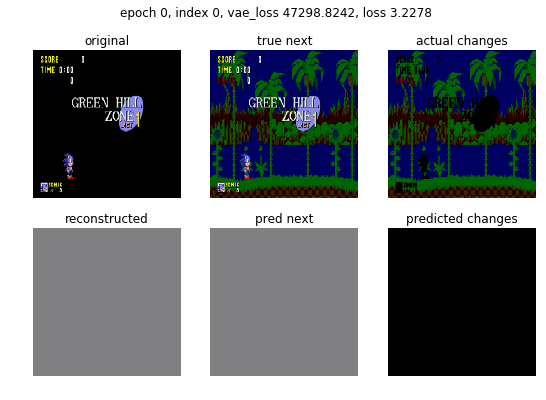

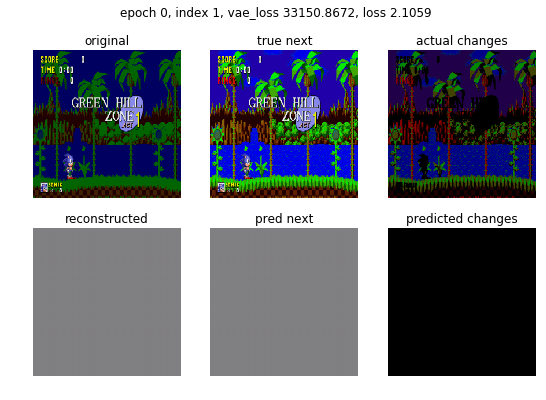

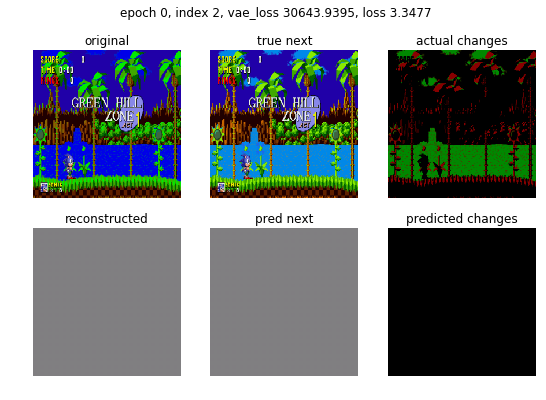

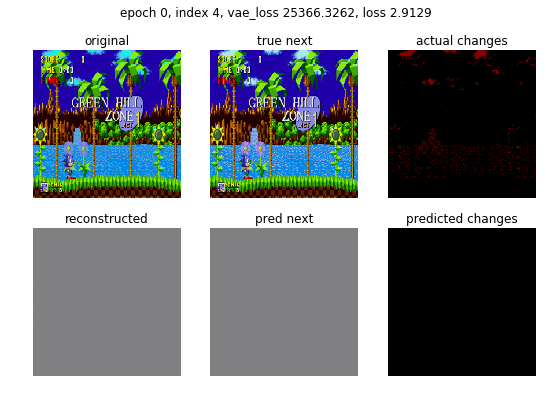

In [18]:
plot_results(loader_test, n=4, epoch=epoch)

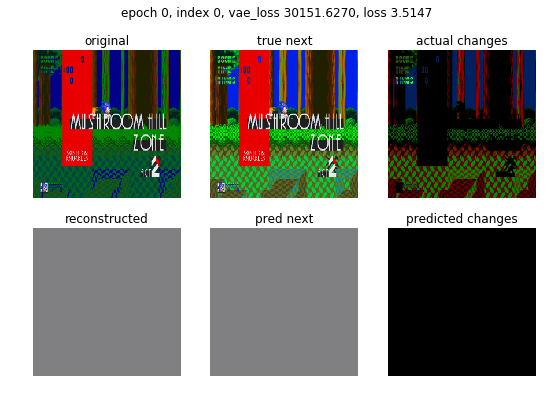

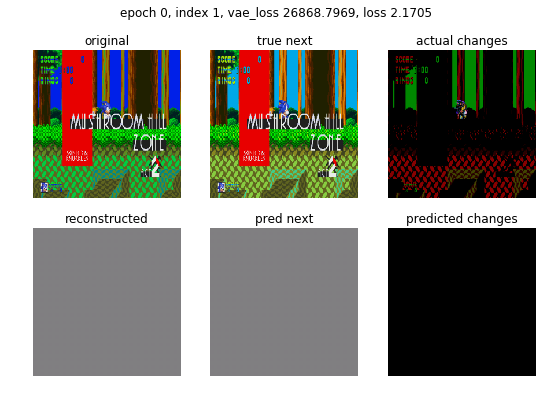

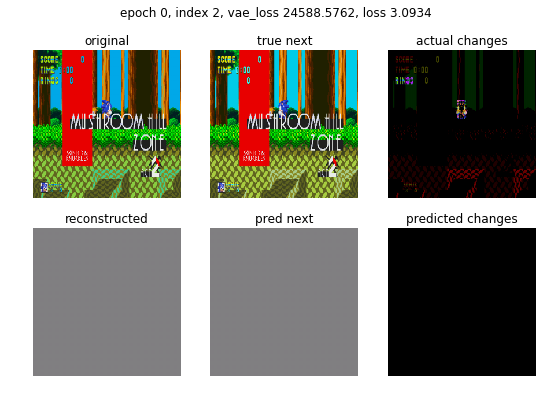

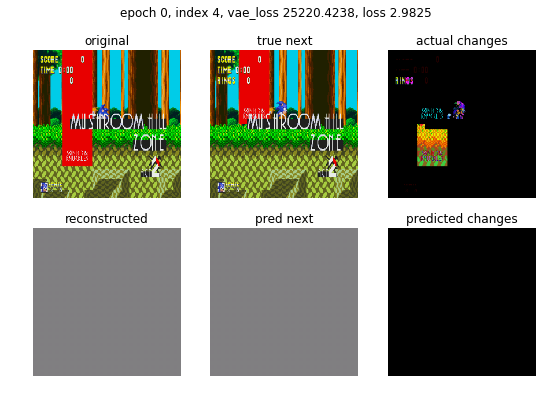

In [19]:
plot_results(loader_train, n=4, epoch=epoch)

loss=-3.7780: 6% 1120/20000 [00:20<05:40, 55.42it/s]

# DEBUG can we replace tf_normal with torch normal?

In [ ]:
raise Exception('sd')

In [ ]:
env.close()
from custom_envs.env import make_env
current_env_name= 'sonic'
env = make_env(current_env_name)

In [ ]:
# DEBUG run one train in global scope
# env.close()

batch_size = 20
num_batches = 1000
num_epochs = 20





# do a rollout
actions = []
observations = []
rewards=[]

observation = env.reset()
for i in range(batch_size):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    actions.append(action)
    observations.append(observation)
    rewards.append(reward)
    if done:
        observation = env.reset()

# stack
actions = np.stack(actions)
observations = np.stack(observations)
rewards = np.stack(rewards)
#         actions.shape

# Run VAE
X = Variable(torch.from_numpy(observations)).cuda().transpose(1,3).contiguous()
Y, mu, logvar = vae.forward(X)

z = vae.sample(mu, logvar).data.cpu().numpy()
#         z.shape

# Stack into sequences
actions = timeseries_to_seq(actions, window=seq_len)
z = timeseries_to_seq(z, window=seq_len)

# Forward
z_v = Variable(torch.from_numpy(z)).cuda()
actions_v = Variable(torch.from_numpy(actions.astype(np.uint8))).float().cuda()
if cuda:
    z_v=z_v.cuda()
    actions_v=actions_v.cuda()
pi, mean, sigma, hidden_state = mdnrnn.forward(z_v, actions_v)

loss = mdnrnn.rnn_loss(z_v, pi, mean, sigma).mean()
print(loss)
optimizer.zero_grad()
# loss.sum().backward()
optimizer.step()

# env.close()

In [ ]:
env.close()

In [ ]:
# # Plot reconstructions
# def plot_results(n=2, epoch=0, batch_size=6, figsize=(9,6)):
#     vae.eval()
#     mdnrnn.eval()
    
#     # do a rollout
#     env = make_env('sonic')
#     try:
#         actions = []
#         observations = []
#         rewards=[]

#         observation = env.reset()
#         for i in range(batch_size):
#             action = env.action_space.sample()
#             observation, reward, done, env_info = env.step(action)
#             actions.append(action)
#             observations.append(observation)
#             rewards.append(reward)
#             if done:
#                 observation = env.reset()
#     except:
#         env.close()
#         raise
#     else:
#         env.close()

#     # stack
#     actions = np.stack(actions)
#     observations = np.stack(observations)
#     rewards = np.stack(rewards)

#     # Run VAE
#     X = Variable(torch.from_numpy(observations)).cuda().transpose(1,3).contiguous()
#     Y, mu, logvar = vae.forward(X)
#     z = vae.sample(mu, logvar).data.cpu().numpy()
#     loss_vae = loss_function(Y, X, mu, logvar)

#     # Stack into sequences
#     # TODO stack as torch vars
#     actions = timeseries_to_seq(actions, window=seq_len)
#     z = timeseries_to_seq(z, window=seq_len)

#     # Forward
#     z_v = Variable(torch.from_numpy(z)).cuda()
#     actions_v = Variable(torch.from_numpy(actions.astype(np.uint8))).float().cuda()
#     if cuda:
#         z_v=z_v.cuda()
#         actions_v=actions_v.cuda()
#     pi, mu, sigma, hidden_state = mdnrnn.forward(z_v, actions_v)

#     loss = mdnrnn.rnn_loss(z_v, pi, mu, sigma)

#     y=Y.cpu().data.transpose(1,3).numpy()
    
#     # TODO tidy the following few lines
#     seq_len2 = mu.size(1)
#     mu = mu.mean(2).view((batch_size*seq_len2, mdnrnn.z_dim))
#     X_pred = vae.decode(mu)
#     _, channels, height, width = X.size()
#     X_pred = X_pred.view((batch_size, seq_len2, channels, height, width))
#     X_pred = X_pred[:, -1]
    
#     for i in np.linspace(0,batch_size-2,n):
#         i=int(i)
        
        
#         x_orig = X[i].transpose(0,2).data.cpu().numpy()
#         x_next = X[i+1].transpose(0,2).data.cpu().numpy()
#         x_pred = X_pred[i].transpose(0,2).data.cpu().numpy()
#         loss_vae_i = loss_vae[i].cpu().data.item()
#         loss_i = loss[i].cpu().data.item()
        
#         plt.figure(figsize=figsize)
        
#         plt.subplot(2, 3, 1)
#         plt.axis("off")
#         plt.title('original')
#         plt.imshow(x_orig)

#         plt.subplot(2, 3, 4)
#         plt.axis("off")
#         plt.imshow(y[i])
#         plt.title('reconstructed')
           
#         plt.subplot(2, 3, 2)
#         plt.axis("off")
#         plt.imshow(x_next)
#         plt.title('true next')
        
#         plt.subplot(2, 3, 5)
#         plt.axis("off")
#         plt.imshow(x_pred)
#         plt.title('pred next')
        
#         plt.subplot(2, 3, 3)
#         plt.axis("off")
#         plt.imshow(np.abs(x_orig-x_next))
#         plt.title('actual changes')
        
#         plt.subplot(2, 3, 6)
#         plt.axis("off")
#         plt.imshow(np.abs(y[i]-x_pred))
#         plt.title('predicted changes')

#         plt.suptitle('epoch {}, index {}, vae_loss {:2.4f}, loss {:2.4f}'.format(epoch, i, loss_vae[i].cpu().data.item(), loss[i].cpu().data.item()))
# #         plt.subplots_adjust(wspace=-.4, hspace=.1)#, bottom=0.1, right=0.8, top=0.9)
#         plt.show()
        


In [ ]:
# import collections

# def train(make_env, vae, mdnrnn, optimizer, test=False, cuda=True, batch_size=30, num_batches=100):
#     try:
#         env=make_env('sonic')
#         vae.eval()
#         if test:
#             mdnrnn.eval()
#         else:
#             mdnrnn.train()
#         info = collections.defaultdict(list)

#         with tqdm(total=num_batches*batch_size, mininterval=0.5, desc='test' if test else 'training') as prog:
#             for i in range(num_batches):
#                 # do a rollout
#                 actions = []
#                 observations = []
#                 rewards=[]

#                 observation = env.reset()
#                 for i in range(batch_size):
#                     action = env.action_space.sample()
#                     observation, reward, done, env_info = env.step(action)
#                     actions.append(action)
#                     observations.append(observation)
#                     rewards.append(reward)
#                     if done:
#                         observation = env.reset()

#                 # stack
#                 actions = np.stack(actions)
#                 observations = np.stack(observations)
#                 rewards = np.stack(rewards)

#                 # Run VAE
#                 X = Variable(torch.from_numpy(observations)).cuda().transpose(1,3).contiguous()
#                 Y, mu, logvar = vae.forward(X)
#                 z = vae.sample(mu, logvar).data.cpu().numpy()
# #                 vae_loss = loss_function(Y, X, mu, logvar).sum()

#                 # Stack into sequences
#                 # TODO stack as torch vars
#                 actions = timeseries_to_seq(actions, window=seq_len)
#                 z = timeseries_to_seq(z, window=seq_len)

#                 # Forward
#                 z_v = Variable(torch.from_numpy(z))
#                 actions_v = Variable(torch.from_numpy(actions.astype(np.uint8))).float()
#                 if cuda:
#                     z_v=z_v.cuda()
#                     actions_v=actions_v.cuda()
#                 pi, mu, sigma, hidden_state = mdnrnn.forward(z_v, actions_v)

#                 loss = mdnrnn.rnn_loss(z_v, pi, mu, sigma).mean()
#                 info['loss'].append(loss.cpu().data.numpy())

#                 if not test:
#                     optimizer.zero_grad()
#                     loss.backward()
#                     optimizer.step()

#                 prog.update(batch_size)
#                 prog.desc='loss={:2.4f}'.format(np.mean(info['loss']))

#             print('[{}/{}] loss={:2.4f}'.format(i, num_batches*batch_size, np.mean(info['loss'])))
#             prog.close()
#             env.close()
#     except:
#         env.close()
#         raise
#     return info

In [ ]:
# import collections

# def train(make_env, vae, mdnrnn, optimizer, test=False, cuda=True, batch_size=30, num_batches=100):
#     try:
#         vae.eval()
#         if test:
#             mdnrnn.eval()
#         else:
#             mdnrnn.train()
#         info = collections.defaultdict(list)

#         with tqdm(total=num_batches*batch_size, mininterval=0.5, desc='test' if test else 'training') as prog:
#             for i in range(num_batches):
#                 # do a rollout
#                 actions = []
#                 observations = []
#                 rewards=[]
                
#                 for i in range(batch_size):
#                     env=make_env('sonic')
#                     observation = env.reset()
#                     actions.append([])
#                     observations.append([])
#                     rewards.append([])
#                     for j in range(seq_len):
#                         action = env.action_space.sample()
#                         observation, reward, done, env_info = env.step(action)
#                         actions[-1].append(action)
#                         observations[-1].append(observation)
#                         rewards[-1].append(reward)
#                         if done:
#                             observation = env.reset()
#                     env.close()

#                 # stack
#                 actions = np.stack(actions)
#                 observations = np.stack(observations)
#                 rewards = np.stack(rewards)

#                 # Run VAE
#                 # the VAE expect (batch, channels, height, width) so we need to reshape
#                 _, _, width, height,channels = observations.shape
#                 X = Variable(torch.from_numpy(observations)).cuda().transpose(2,4).contiguous()
#                 X = X.view(batch_size*seq_len, channels, height, width)
#                 Y, mu, logvar = vae.forward(X)
#                 z_v = vae.sample(mu, logvar)
#                 z_v = z_v.view(batch_size, seq_len, -1)
                
#                 # TODO I should pregenerate the rollouts

#                 # Forward
#                 actions_v = Variable(torch.from_numpy(actions.astype(np.uint8))).float()
#                 if cuda:
#                     z_v=z_v.cuda()
#                     actions_v=actions_v.cuda()
#                 pi, mu, sigma, hidden_state = mdnrnn.forward(z_v, actions_v)

#                 loss = mdnrnn.rnn_loss(z_v, pi, mu, sigma).mean()
#                 info['loss'].append(loss.cpu().data.numpy())

#                 if not test:
#                     optimizer.zero_grad()
#                     loss.backward()
#                     optimizer.step()

#                 prog.update(batch_size)
#                 prog.desc='loss={:2.4f}'.format(np.mean(info['loss']))

#             print('[{}/{}] loss={:2.4f}'.format(i, num_batches*batch_size, np.mean(info['loss'])))
#             prog.close()
#             env.close()
#     except:
#         env.close()
#         raise
#     return info